In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.9.1


In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('../data/fruits-360_dataset/fruits-360/Training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
test_dir = Path('../data/fruits-360_dataset/fruits-360/Test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
        
    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    
    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [5]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)

In [6]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 67692

Number of different labels: 131

Labels: ['Salak' 'Grape Blue' 'Pepper Orange' 'Onion Red Peeled' 'Tomato Maroon'
 'Nut Pecan' 'Physalis' 'Tomato Heart' 'Pear Red' 'Cherry 2'
 'Cherry Wax Red' 'Kumquats' 'Cherry Rainier' 'Apple Granny Smith'
 'Melon Piel de Sapo' 'Kaki' 'Apple Pink Lady' 'Raspberry' 'Pear Stone'
 'Apple Red 1' 'Eggplant' 'Tomato 4' 'Apricot' 'Orange' 'Watermelon'
 'Cantaloupe 2' 'Lemon Meyer' 'Mangostan' 'Corn' 'Pepper Yellow'
 'Tomato 3' 'Pepper Red' 'Cantaloupe 1' 'Pear 2' 'Apple Red Delicious'
 'Pomegranate' 'Grapefruit White' 'Apple Golden 2' 'Pear Williams'
 'Chestnut' 'Cherry Wax Yellow' 'Maracuja' 'Blueberry' 'Nectarine'
 'Pomelo Sweetie' 'Apple Red 3' 'Avocado' 'Mandarine' 'Dates' 'Lychee'
 'Physalis with Husk' 'Pepino' 'Clementine' 'Tamarillo' 'Mango'
 'Redcurrant' 'Pineapple' 'Walnut' 'Limes' 'Nut Forest' 'Lemon' 'Fig'
 'Cucumber Ripe 2' 'Plum 3' 'Apple Golden 1' 'Kiwi' 'Papaya'
 'Apple Red Yellow 2' 'Onion White

In [7]:
train_df.head(5)

,Filepath,Label
0,..\data\fruits-360_dataset\fruits-360\Training...,Salak
1,..\data\fruits-360_dataset\fruits-360\Training...,Grape Blue
2,..\data\fruits-360_dataset\fruits-360\Training...,Pepper Orange
3,..\data\fruits-360_dataset\fruits-360\Training...,Grape Blue
4,..\data\fruits-360_dataset\fruits-360\Training...,Onion Red Peeled


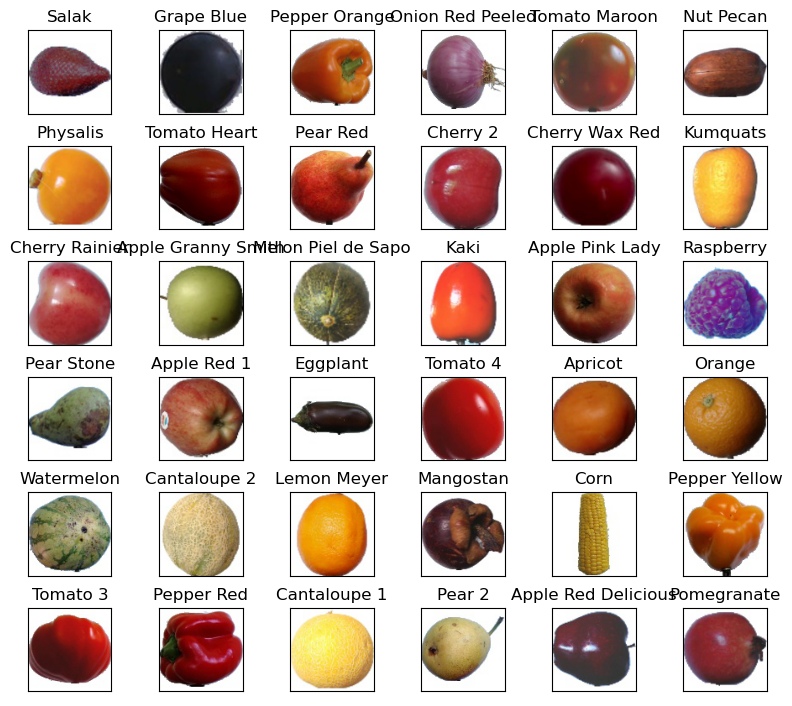

In [8]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 67692 validated image filenames belonging to 131 classes.


In [11]:
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 22688 validated image filenames belonging to 131 classes.


In [68]:
val_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 22688 validated image filenames belonging to 131 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [23]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(131, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [24]:
# Set the device to CPU
with tf.device('/cpu:0'): 
    history = model.fit(
        train_images,
        validation_data=test_images,
        batch_size = 32,
        epochs=5,
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 patience=2,
#                 restore_best_weights=True
#             )
#         ]
    )

Epoch 1/5
2116/2116 [==============================] - 694s 326ms/step - loss: 0.2301 - accuracy: 0.9496 - val_loss: 0.1389 - val_accuracy: 0.9621
Epoch 2/5
2116/2116 [==============================] - 571s 270ms/step - loss: 0.0279 - accuracy: 0.9924 - val_loss: 0.1743 - val_accuracy: 0.9539
Epoch 3/5
2116/2116 [==============================] - 572s 270ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.1209 - val_accuracy: 0.9728
Epoch 4/5
2116/2116 [==============================] - 579s 273ms/step - loss: 0.0187 - accuracy: 0.9950 - val_loss: 0.1927 - val_accuracy: 0.9617
Epoch 5/5
2116/2116 [==============================] - 584s 276ms/step - loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.2254 - val_accuracy: 0.9561


In [25]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

709/709 [==============================] - 153s 214ms/step


['Hazelnut',
 'Mango',
 'Banana',
 'Corn Husk',
 'Pear 2',
 'Physalis with Husk',
 'Hazelnut',
 'Redcurrant',
 'Grape White',
 'Grape Blue',
 'Plum 3',
 'Pear Williams',
 'Grapefruit White',
 'Cantaloupe 2',
 'Tamarillo',
 'Pepper Yellow',
 'Fig',
 'Potato Red',
 'Plum 3',
 'Pepper Orange',
 'Limes',
 'Cantaloupe 1',
 'Cucumber Ripe',
 'Tomato 3',
 'Tomato not Ripened',
 'Potato White',
 'Pear Forelle',
 'Tomato 3',
 'Cherry Wax Yellow',
 'Hazelnut',
 'Pear Red',
 'Mangostan',
 'Ginger Root',
 'Strawberry Wedge',
 'Pear Red',
 'Apple Crimson Snow',
 'Passion Fruit',
 'Mulberry',
 'Pear Red',
 'Tomato Maroon',
 'Kiwi',
 'Grape Blue',
 'Redcurrant',
 'Apple Red 1',
 'Mangostan',
 'Cantaloupe 1',
 'Maracuja',
 'Peach Flat',
 'Watermelon',
 'Nut Forest',
 'Rambutan',
 'Tomato Heart',
 'Cherry 2',
 'Pear Forelle',
 'Peach',
 'Onion Red Peeled',
 'Cucumber Ripe 2',
 'Pepper Orange',
 'Pepper Green',
 'Grape Blue',
 'Mandarine',
 'Pineapple Mini',
 'Grape Pink',
 'Apricot',
 'Pomelo Sweetie',

In [32]:
img = output('../data/fruits-360_dataset/fruits-360/Test/Banana/100_100.jpg')
img

1/1 [==============================] - 0s 26ms/step


'Banana'

In [40]:
img = output('../data/fruits-360_dataset/test-multiple_fruits/chestnut1.jpg')
img

1/1 [==============================] - 0s 27ms/step


'Nut Pecan'

In [33]:
model.save('Fruit360_V1.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


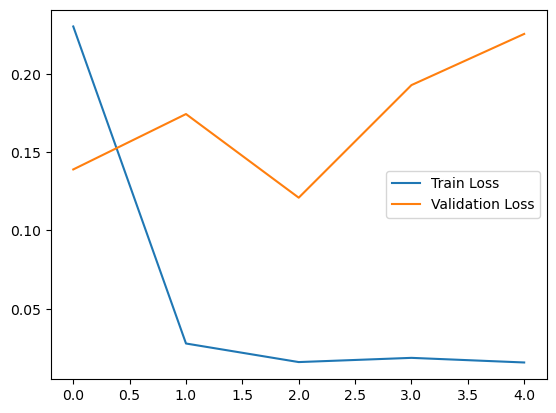

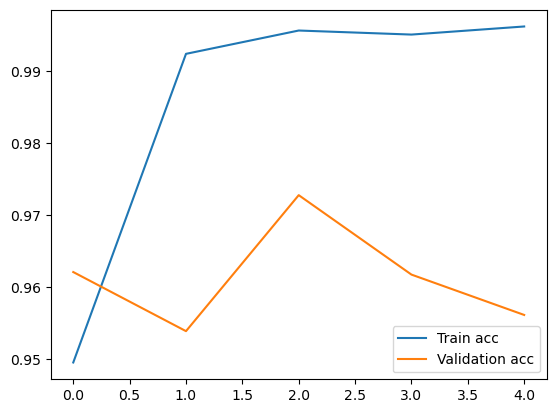

In [42]:
print(history.history.keys())
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()